In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import sklearn

# Tools for splitting data into train/test sets and performing hyperparameter optimization
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold

# LabelEncoder: converts categorical labels into numbers; StandardScaler: normalizes data
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Metrics for evaluating model performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier



In [43]:
# Load data
file_path = 'spotify_tracks.csv'
spotify_tracks = pd.read_csv(file_path)

In [97]:
# Display basic info about the dataset
print(spotify_tracks.info())
print(spotify_tracks.isnull().sum())

# Display the first few rows of the dataset
spotify_tracks['track_genre'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 19000 to 81999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        5000 non-null   int64  
 1   duration_ms       5000 non-null   int64  
 2   explicit          5000 non-null   bool   
 3   danceability      5000 non-null   float64
 4   energy            5000 non-null   float64
 5   key               5000 non-null   int64  
 6   loudness          5000 non-null   float64
 7   mode              5000 non-null   int64  
 8   speechiness       5000 non-null   float64
 9   acousticness      5000 non-null   float64
 10  instrumentalness  5000 non-null   float64
 11  liveness          5000 non-null   float64
 12  valence           5000 non-null   float64
 13  tempo             5000 non-null   float64
 14  track_genre       5000 non-null   object 
dtypes: bool(1), float64(9), int64(4), object(1)
memory usage: 590.8+ KB
None
popularity      

track_genre
country    1000
edm        1000
hip-hop    1000
latin      1000
pop        1000
Name: count, dtype: int64

In [46]:
# Filter dataset to include only selected genres
selected_genres = ['pop', 'country', 'hip-hop', 'punk_rock', 'latin', 'edm']
spotify_tracks = spotify_tracks[spotify_tracks['track_genre'].isin(selected_genres)]

In [47]:
# Drop unnecessary columns
columns_to_drop = ['Unnamed: 0', 'track_id', 'track_name', 'artists', 'album_name', 'time_signature']
spotify_tracks.drop(columns=columns_to_drop, axis=1, inplace=True)

In [48]:
# Handle missing values
print("Missing values before dropping:", spotify_tracks.isnull().sum())
spotify_tracks.dropna(inplace=True)
print("Missing values after dropping:", spotify_tracks.isnull().sum())

Missing values before dropping: popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
track_genre         0
dtype: int64
Missing values after dropping: popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
track_genre         0
dtype: int64


In [49]:
# Separate features and target
features = spotify_tracks.drop(columns=['track_genre'])
target = spotify_tracks['track_genre']

In [50]:
# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [51]:
# Initialize LabelEncoder to convert genre labels to numbers
label_encoder = LabelEncoder()

# Fit the label encoder on the training labels and transform all sets
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [ ]:
# Normalize features
scaler = StandardScaler()

# Fit the scaler on the training data and transform all sets
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

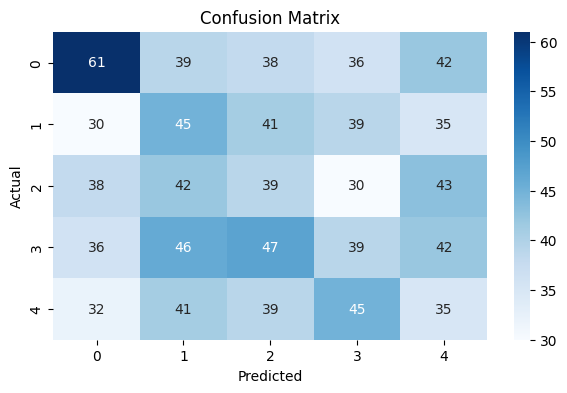

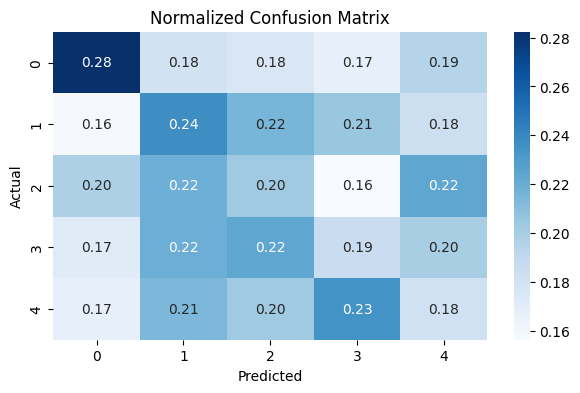

Test Accuracy: 0.7000

Confusion Matrix: 
 [[155  12   5   2  12]
 [ 12 162  16  11  19]
 [  6  14 136  34  33]
 [ 19   5  22 123   9]
 [  5  20  25  19 124]]


In [98]:
# Initialize the Random Forest Classifier with a fixed random state for reproducibility
rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_val)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Normalized Confusion Matrix for better clarity (shows percentages per actual class)
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(7, 4))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

test_accuracy = accuracy_score(y_val, y_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')
print('\nConfusion Matrix: \n', confusion_matrix(y_val, y_pred))


In [60]:
# Hyperparameter tuning using GridSearchCV
PARAM_GRID = {
    'n_estimators': [10, 100, 200, 300], # Number of trees in the forest
    'max_depth': [3, 5, 10, 20, None], # Maximum depth of the tree
    'max_features':['sqrt', 'log2', None], # Number of features to consider at each split
    'min_samples_leaf': [1, 2, 4], # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False] # Whether bootstrap samples are used 
}

In [61]:
# Initialize Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with 10-fold cross-validation
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=PARAM_GRID,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores
    verbose=2,  # Show progress
    return_train_score=True
)

In [62]:
# Fit the grid search to the training data
print("Starting grid search...")
grid_search.fit(X_train, y_train)
print("Grid search completed!")

Starting grid search...
Fitting 10 folds for each of 360 candidates, totalling 3600 fits
Grid search completed!


In [ ]:
# Get the best estimator from grid search
best_rf = grid_search.best_estimator_

# Print best parameters and score
print("\n=== Best Model Results ===")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Evaluate on validation set
val_accuracy = best_rf.score(X_val, y_val)
print(f"Validation set accuracy: {val_accuracy:.4f}")

# Evaluate on test set
test_accuracy = best_rf.score(X_test, y_test)
print(f"Test set accuracy: {test_accuracy:.4f}")

# Generate classification report
y_pred = best_rf.predict(X_test)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))


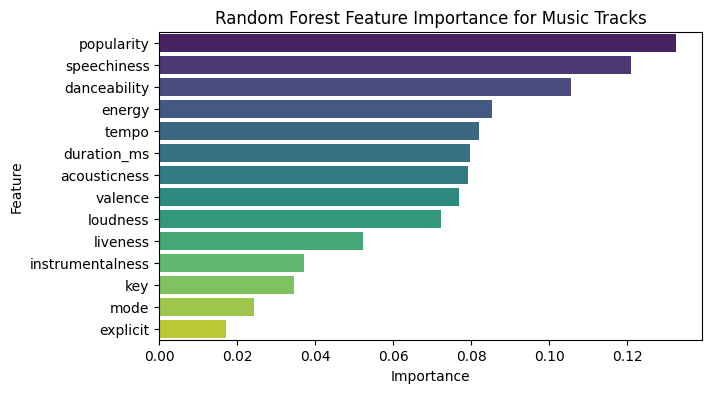

In [94]:
# Get feature importances from the best model
feature_importance = best_rf.feature_importances_
feature_names = features.columns  # Using the features DataFrame columns

# Sort features by importance
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_features = feature_names[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

# Create feature importance DataFrame for better visualization
# Insert your seaborn feature importance plot here:
importance_df = pd.DataFrame({
    'Feature': np.array(feature_names)[sorted_indices],
    'Importance': feature_importance[sorted_indices]
})

plt.figure(figsize=(7, 4))
sns.barplot(x='Importance', y='Feature', data=importance_df, hue='Feature', palette='viridis', dodge=False, legend=False)
plt.title('Random Forest Feature Importance for Music Tracks')
plt.show()


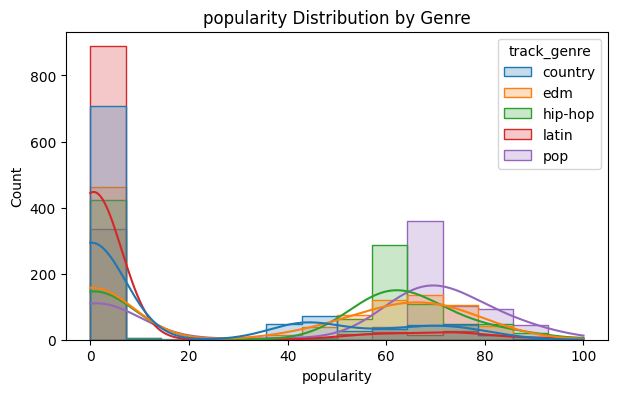

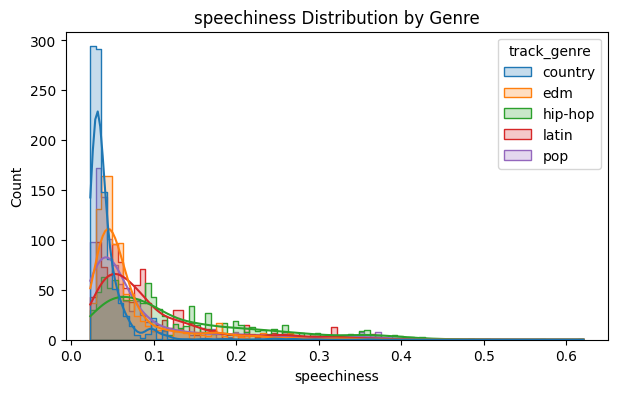

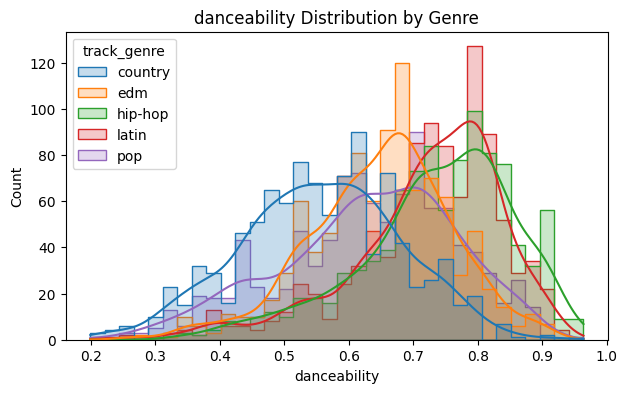

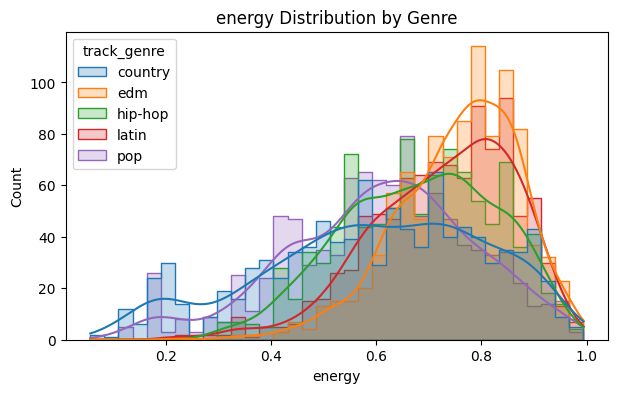

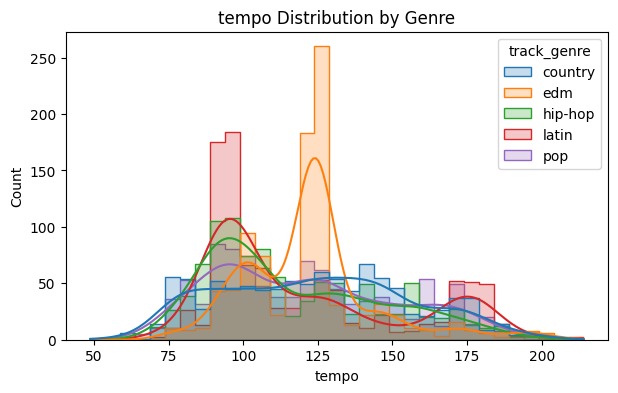

In [99]:
# Get the feature importance scores from the best trained Random Forest model
feature_importance = best_rf.feature_importances_


# Get the feature names from the original dataset before scaling
feature_names = features.columns

# Sort the indices of the features by their importance in descending order
sorted_indices = np.argsort(feature_importance)[::-1]

# Select the top 5 most important features based on their importance scores
top5_features = feature_names[sorted_indices][:5]

for col in top5_features:
    plt.figure(figsize=(7, 4)) # Create a new figure with specific size
    sns.histplot(
        data=spotify_tracks,      # Data source
        x=col,                    # Current feature/column to plot
        hue='track_genre',        # Color-code by music genre
        kde=True,                 # Add Kernel Density Estimate curve
        element='step',           # Display histogram as step lines
        common_norm=False         # Normalize counts separately per genre
    )
    
    plt.title(f"{col} Distribution by Genre")  # Add plot title
    plt.show()  


In [ ]:
# Save the best model to disk
model_filename = 'best_random_forest_model.pkl'
joblib.dump(best_rf, model_filename)
print(f"\nBest model saved as {model_filename}")


Best model saved as best_random_forest_model.pkl
